神经网络架构摘要
网络层数: 3 (包含2个隐藏层和1个输出层)
输入层神经元数: 2
隐藏层 1: 1000 个神经元, 激活函数: relu
隐藏层 2: 1000 个神经元, 激活函数: tanh
输出层: 1 个神经元, 激活函数: sigmoid
总参数数量: 1005001
迭代次数:    0 | 损失: 0.885517 | 准确率: 50.65%
迭代次数:  200 | 损失: 0.329670 | 准确率: 86.75%
迭代次数:  400 | 损失: 0.207840 | 准确率: 91.50%
迭代次数:  600 | 损失: 0.166771 | 准确率: 93.40%
迭代次数:  800 | 损失: 0.143639 | 准确率: 94.55%
迭代次数: 1000 | 损失: 0.128560 | 准确率: 95.00%
迭代次数: 1200 | 损失: 0.117691 | 准确率: 95.50%
迭代次数: 1400 | 损失: 0.109413 | 准确率: 95.60%
迭代次数: 1600 | 损失: 0.102827 | 准确率: 95.90%
迭代次数: 1800 | 损失: 0.097485 | 准确率: 96.05%
训练完成! 最终损失: 0.087616, 最终准确率: 95.25%


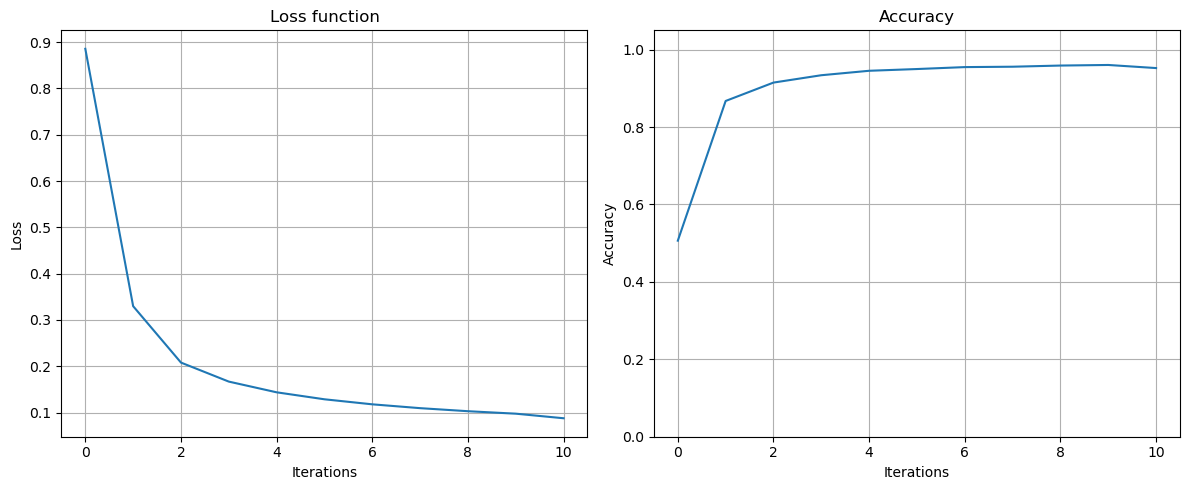

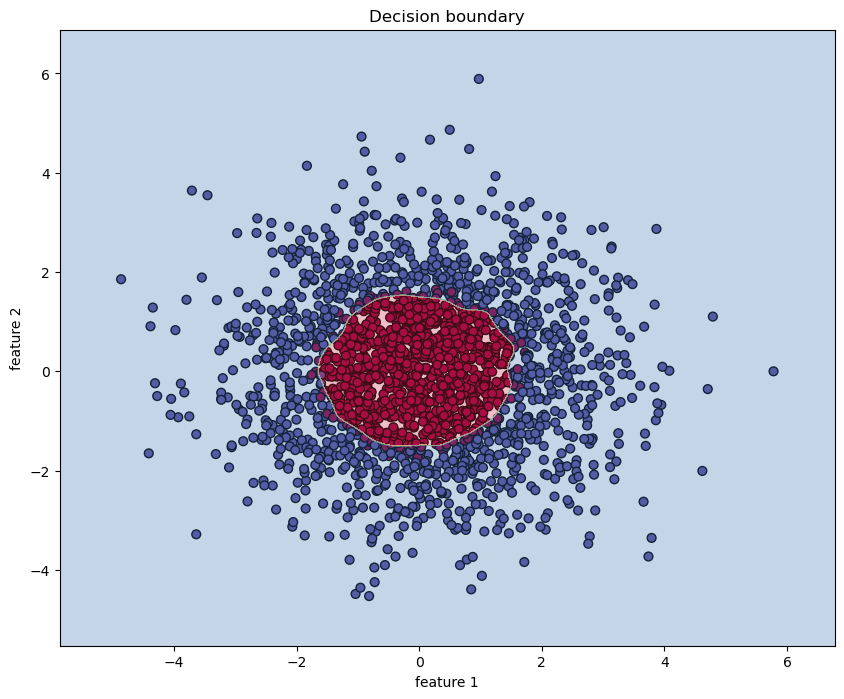

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

class DeepNeuralNetwork:
    def __init__(self, layers_dims, hidden_activations='relu'):
        """
        初始化深度神经网络
        
        参数:
        layers_dims -- 包含每层神经元数量的列表 [输入层, 隐藏层1, ..., 输出层]
        hidden_activations -- 隐藏层激活函数名称('relu', 'sigmoid', 'tanh')或各层激活函数列表
        """
        self.layers_dims = layers_dims
        self.L = len(layers_dims) - 1  # 网络层数（不包括输入层）
        
        # 处理激活函数参数
        if isinstance(hidden_activations, list):
            if len(hidden_activations) != self.L - 1:
                raise ValueError("激活函数列表长度应与隐藏层数量一致")
            self.activations = ['none'] + hidden_activations + ['sigmoid']
        else:
            self.activations = ['none'] + [hidden_activations] * (self.L - 1) + ['sigmoid']
        
        # 初始化参数
        self.parameters = {}
        self.initialize_parameters()
        
        # 存储训练信息
        self.costs = []
        self.accuracies = []
    
    def initialize_parameters(self):
        """使用He初始化方法初始化网络参数"""
        np.random.seed(1)
        self.total_parameters = 0
        
        for l in range(1, self.L + 1):
            # He初始化
            self.parameters['W' + str(l)] = np.random.randn(
                self.layers_dims[l], self.layers_dims[l-1]
            ) * np.sqrt(2. / self.layers_dims[l-1])
            
            self.parameters['b' + str(l)] = np.zeros((self.layers_dims[l], 1))
            
            # 统计参数数量
            self.total_parameters += self.layers_dims[l] * self.layers_dims[l-1]
            self.total_parameters += self.layers_dims[l]
    
    def activation(self, Z, activation_type):
        """激活函数"""
        if activation_type == 'sigmoid':
            return 1 / (1 + np.exp(-Z)), Z
        elif activation_type == 'relu':
            return np.maximum(0, Z), Z
        elif activation_type == 'tanh':
            return np.tanh(Z), Z
        elif activation_type == 'none':
            return Z, Z
        else:
            raise ValueError(f"不支持的激活函数: {activation_type}")
    
    def activation_derivative(self, dA, cache, activation_type):
        """激活函数导数"""
        Z = cache
        
        if activation_type == 'sigmoid':
            s = 1 / (1 + np.exp(-Z))
            return dA * s * (1 - s)
        elif activation_type == 'relu':
            dZ = np.array(dA, copy=True)
            dZ[Z <= 0] = 0
            return dZ
        elif activation_type == 'tanh':
            return dA * (1 - np.tanh(Z)**2)
        elif activation_type == 'none':
            return dA
        else:
            raise ValueError(f"不支持的激活函数: {activation_type}")
    
    def forward_propagation(self, X):
        """前向传播"""
        caches = []
        A = X
        caches.append(('A0', A))  # 存储输入层
        
        # 隐藏层前向传播
        for l in range(1, self.L):
            W = self.parameters['W' + str(l)]
            b = self.parameters['b' + str(l)]
            Z = np.dot(W, A) + b
            A, linear_cache = self.activation(Z, self.activations[l])
            caches.append(('Z' + str(l), linear_cache))
            caches.append(('A' + str(l), A))
        
        # 输出层前向传播
        W = self.parameters['W' + str(self.L)]
        b = self.parameters['b' + str(self.L)]
        Z = np.dot(W, A) + b
        AL, linear_cache = self.activation(Z, self.activations[self.L])
        caches.append(('Z' + str(self.L), linear_cache))
        caches.append(('A' + str(self.L), AL))
        
        return AL, caches
    
    def compute_cost(self, AL, Y):
        """计算二元交叉熵损失"""
        m = Y.shape[1]
        cost = -np.mean(Y * np.log(AL + 1e-8) + (1 - Y) * np.log(1 - AL + 1e-8))
        return np.squeeze(cost)
    
    def backward_propagation(self, AL, Y, caches):
        """反向传播"""
        grads = {}
        m = Y.shape[1]
        
        # 将缓存列表转为字典
        cache_dict = {key: value for key, value in caches}
        
        # 初始化反向传播
        dAL = - (np.divide(Y, AL + 1e-8) - np.divide(1 - Y, 1 - AL + 1e-8))
        
        # 输出层梯度
        current_cache = cache_dict['Z' + str(self.L)]
        dZ = self.activation_derivative(dAL, current_cache, self.activations[self.L])
        A_prev = cache_dict['A' + str(self.L-1)]
        grads['dW' + str(self.L)] = np.dot(dZ, A_prev.T) / m
        grads['db' + str(self.L)] = np.sum(dZ, axis=1, keepdims=True) / m
        
        dA_prev = np.dot(self.parameters['W' + str(self.L)].T, dZ)
        
        # 隐藏层梯度
        for l in reversed(range(1, self.L)):
            dA = dA_prev
            current_cache = cache_dict['Z' + str(l)]
            dZ = self.activation_derivative(dA, current_cache, self.activations[l])
            A_prev = cache_dict['A' + str(l-1)]
            grads['dW' + str(l)] = np.dot(dZ, A_prev.T) / m
            grads['db' + str(l)] = np.sum(dZ, axis=1, keepdims=True) / m
            dA_prev = np.dot(self.parameters['W' + str(l)].T, dZ)
        
        return grads
    
    def update_parameters(self, grads, learning_rate):
        """使用梯度下降更新参数"""
        for l in range(1, self.L + 1):
            self.parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
            self.parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    
    def compute_accuracy(self, predictions, Y):
        """计算准确率"""
        return np.mean((predictions >= 0.5) == Y)
    
    def predict(self, X):
        """预测函数"""
        AL, _ = self.forward_propagation(X)
        predictions = (AL >= 0.5).astype(int)
        return predictions
    
    def fit(self, X, Y, learning_rate=0.01, num_iterations=1000, print_cost=True, print_every=100):
        """
        训练神经网络
        
        参数:
        X -- 输入数据 (特征数, 样本数)
        Y -- 真实标签 (1, 样本数)
        learning_rate -- 学习率
        num_iterations -- 迭代次数
        print_cost -- 是否打印损失
        print_every -- 打印间隔
        """
        np.random.seed(1)
        
        for i in range(num_iterations):
            # 前向传播
            AL, caches = self.forward_propagation(X)
            
            # 计算损失
            cost = self.compute_cost(AL, Y)
            
            # 反向传播
            grads = self.backward_propagation(AL, Y, caches)
            
            # 更新参数
            self.update_parameters(grads, learning_rate)
            
            # 记录损失和准确率
            if i % print_every == 0 or i == num_iterations - 1:
                self.costs.append(cost)
                predictions = self.predict(X)
                accuracy = self.compute_accuracy(predictions, Y)
                self.accuracies.append(accuracy)
                
                if print_cost and i % print_every == 0:
                    print(f"迭代次数: {i:4d} | 损失: {cost:.6f} | 准确率: {accuracy*100:.2f}%")
        
        # 训练结束打印最终结果
        final_prediction = self.predict(X)
        final_accuracy = self.compute_accuracy(final_prediction, Y)
        print(f"训练完成! 最终损失: {cost:.6f}, 最终准确率: {final_accuracy*100:.2f}%")
    
    def plot_learning_curve(self):
        """绘制学习曲线"""
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.costs)
        plt.title("Loss function")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(self.accuracies)
        plt.title("Accuracy")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.ylim([0, 1.05])
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def summary(self):
        """打印网络摘要信息"""
        print("="*50)
        print("神经网络架构摘要")
        print("="*50)
        print(f"网络层数: {self.L} (包含{self.L-1}个隐藏层和1个输出层)")
        print(f"输入层神经元数: {self.layers_dims[0]}")
        
        for l in range(1, self.L):
            print(f"隐藏层 {l}: {self.layers_dims[l]} 个神经元, 激活函数: {self.activations[l]}")
        
        print(f"输出层: {self.layers_dims[self.L]} 个神经元, 激活函数: {self.activations[self.L]}")
        print(f"总参数数量: {self.total_parameters}")
        print("="*50)

# 示例用法
if __name__ == "__main__":
    # 1. 创建模拟数据集
    np.random.seed(42)
    m = 2000  # 样本数量
    n = 2     # 特征数量
    X = np.random.randn(n, m) * 1.5
    Y = np.zeros((1, m))
    
    # 创建非线性可分数据 (两个同心圆)
    for i in range(m):
        distance = np.sqrt(X[0, i]**2 + X[1, i]**2)
        if distance < 1.5 + np.random.rand()*0.3:
            Y[0, i] = 0
        else:
            Y[0, i] = 1
    
    # 2. 定义网络架构
    layers_dims = [n, 1000, 1000, 1]  # 输入层2个神经元，两个隐藏层各5个神经元，输出层1个神经元
    activations = ['relu', 'tanh']  # 第一个隐藏层用ReLU，第二个用tanh
    
    # 3. 初始化网络
    dnn = DeepNeuralNetwork(layers_dims, hidden_activations=activations)
    
    # 4. 打印网络摘要
    dnn.summary()
    
    # 5. 训练网络
    dnn.fit(X, Y, learning_rate=0.1, num_iterations=2000, print_every=200)
    
    # 6. 绘制学习曲线
    dnn.plot_learning_curve()
    
    # 7. 绘制决策边界
    plt.figure(figsize=(10, 8))
    
    # 绘制原始数据点
    plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral, edgecolors='k')
    
    # 绘制决策边界
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # 预测网格点的分类
    Z = dnn.predict(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plt.title("Decision boundary")
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.show()